# Phi_K basic tutorial

This notebook guides you through the basic functionality of the phik package. The package offers functionality on three related topics:

1. Phik correlation matrix
2. Significance matrix
3. Outlier significance matrix

For more information on the undertlaying theory, the user is referred to our paper.

In [1]:
# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

%matplotlib inline

In [2]:
# if one changes something in the phik-package one can automatically reload the package or module
%load_ext autoreload
%autoreload 2

# Load data

A simulated dataset is part of the phik-package. The dataset concerns fake car insurance data. Load the dataset here:

In [3]:
data = pd.read_csv( resources.fixture('fake_insurance_data.csv.gz') )

# Take a first look at the data

Let's use a simple data.head() to get an idea of what the data looks like and inspect the different types of variables.

In [4]:
data.head()

,car_color,driver_age,area,mileage,car_size
0,black,26.377219,suburbs,156806.288398,XXL
1,black,58.976840,suburbs,74400.323559,XL
2,multicolor,55.744988,downtown,267856.748015,XXL
3,metalic,57.629139,downtown,259028.249060,XXL
4,green,21.490637,downtown,110712.216080,XL


# Specify bin types

The phik-package offers a way to calculate correlations between variables of mixed types. Variable types can be inferred automatically although we recommend variable types to be specified by the user. 

Because interval type variables need to be binned in order to calculate phik and the signifiance, a list of interval variables is created.

In [5]:
data_types = {'severity': 'interval',
             'driver_age':'interval',
             'satisfaction':'ordinal',
             'mileage':'interval',
             'car_size':'ordinal',
             'car_use':'ordinal',
             'car_color':'categorical',
             'area':'categorical'}

interval_cols = [col for col, v in data_types.items() if v=='interval' and col in data.columns]
interval_cols

['driver_age', 'mileage']

# Visually inspect pairwise correlations

## Bin the interval variables

To get a feeling for the data, let's bin the interval variables and create 2d histograms to inspect the correlations between variables. By binning the interval variables we can treat all variable types in the same way.


In [6]:
# bin the interval variables
data_binned, binning_dict = bin_data(data, cols=interval_cols, retbins=True)

In [7]:
binning_dict

{'driver_age': [(18.030700817879673, 28.34523864121504),
  (28.34523864121504, 38.659776464550404),
  (38.659776464550404, 48.974314287885775),
  (48.974314287885775, 59.288852111221146),
  (59.288852111221146, 69.60338993455652),
  (69.60338993455652, 79.91792775789187),
  (79.91792775789187, 90.23246558122725),
  (90.23246558122725, 100.54700340456262),
  (100.54700340456262, 110.86154122789799),
  (110.86154122789799, 121.17607905123334)],
 'mileage': [(53.54305708442213, 30047.010932306846),
  (30047.010932306846, 60040.478807529274),
  (60040.478807529274, 90033.94668275169),
  (90033.94668275169, 120027.41455797412),
  (120027.41455797412, 150020.88243319656),
  (150020.88243319656, 180014.35030841897),
  (180014.35030841897, 210007.81818364142),
  (210007.81818364142, 240001.28605886383),
  (240001.28605886383, 269994.75393408624),
  (269994.75393408624, 299988.2218093087)]}

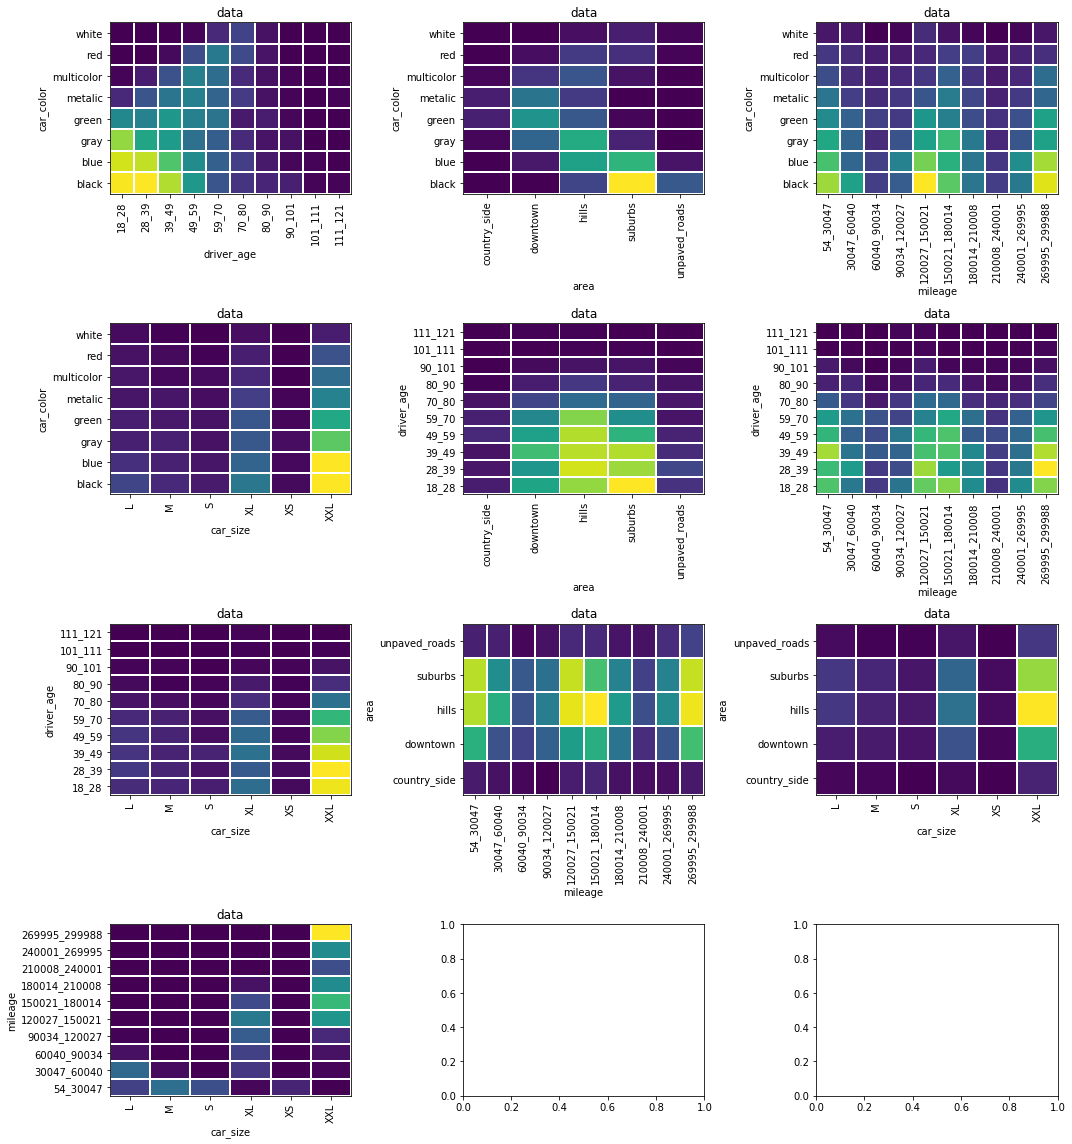

In [8]:
# plot each variable pair
plt.rc('text', usetex=False)

n=0
for i in range(len(data.columns)):
    n=n+i
    
ncols=3
nrows=int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15,4*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # get data
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1])[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # plot data
    img = axes[r][c].pcolormesh(datahist.values, edgecolor='w', linewidth=1)
    
    # axis ticks and tick labels
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # axis labels
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical')
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal')    
    axes[r][c].set_xlabel(datahist.columns.name)
    axes[r][c].set_ylabel(datahist.index.name)    
    axes[r][c].set_title('data')
    
plt.tight_layout()



# Correlation: mileage vs car_size

From the above plots it seems like there might be an interesting a correlation between mileage and car_size. Let's see what phik correlation is measured for this data.

In [9]:
x, y = data[['mileage', 'car_size']].T.values

print('phik         =  %.2f'%phik.phik_from_array(x, y, num_vars=['x']))
print('significance = %.2f'%phik.significance_from_array(x, y, num_vars=['x'])[1])



phik         =  0.77
significance = 49.22


Indeed there is a correlation between these variables and the correlation is also significant. To better understand the correlation, we can have a look at the signficance of excesses and deficits in the 2-dimensional contigency table, so-called "outlier significances".

In [10]:
phik.outlier_significance_from_array(x, y, num_vars=['x'])

y,L,M,S,XL,XS,XXL
53.5_30047.0,6.882155,21.483476,18.076204,-8.209536,10.820863,-22.423985
30047.0_60040.5,20.034528,-0.251737,-3.408409,2.534277,-1.973628,-8.209536
60040.5_90033.9,1.627610,-3.043497,-2.265809,10.215936,-1.246784,-8.209536
90033.9_120027.4,-3.711579,-3.827278,-2.885475,12.999048,-1.638288,-7.185622
120027.4_150020.9,-7.665861,-6.173001,-4.746762,9.629145,-2.841508,-0.504521
150020.9_180014.4,-7.533189,-6.063786,-4.660049,1.559370,-2.785049,6.765549
180014.4_210007.8,-5.541940,-4.425929,-3.360023,-4.802787,-1.942469,10.520540
210007.8_240001.3,-3.496905,-2.745103,-2.030802,-5.850529,-1.100873,8.723925
240001.3_269994.8,-5.275976,-4.207164,-3.186534,-8.616464,-1.830944,13.303101
269994.8_299988.2,-8.014016,-6.458253,-4.973240,-12.868389,-2.989055,20.992824


The values displayed in the matrix are the signficiances of the outlier frequencies, i.e. a large value means that the measured frequency for that bin is significantly different from the expected frequency in that bin.

Let's visualise for easier interpretation.

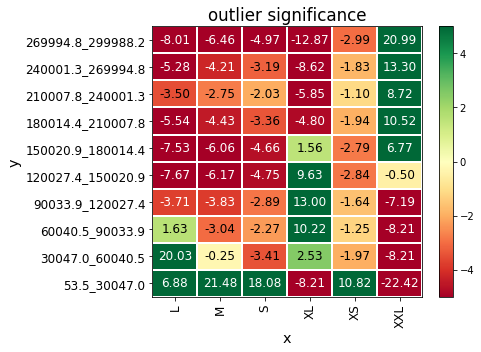

In [11]:
outlier_signifs = phik.outlier_significance_from_array(x, y, num_vars=['x'])

zvalues = outlier_signifs.values
xlabels = outlier_signifs.columns
ylabels = outlier_signifs.index
xlabel = 'x'
ylabel = 'y'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2)

# $\phi_k$ functions for dataframes

In our data we have 5 different columns, meaning we have to evaluate 4+3+2+1=10 pairs of variables for possible correlations. In a large dataset, with many different variables, this can easily become a cumbersome taks. Can we do this more efficient? yes! We have provided functions that work on dataframes, to allow you to calculate the phik correlation, significance and outlier significance for all different variable combinations at once.


The functions are by default available after import of the phik package.

# $\phi_k$ correlation matrix

Now let's start calculating the corrlation phik between pairs of variables. 

Note that the original dataset is used as input, the binning of interval variables is done automatically.

In [12]:
phik_overview = data.phik_matrix(interval_cols=interval_cols)
phik_overview

var2,area,car_color,car_size,driver_age,mileage
var1,,,,,
area,1.000000,0.590456,0.000000,0.105506,0.000000
car_color,0.590456,1.000000,0.000000,0.389671,0.000000
car_size,0.000000,0.000000,1.000000,0.000000,0.768589
driver_age,0.105506,0.389671,0.000000,1.000000,0.000000
mileage,0.000000,0.000000,0.768589,0.000000,1.000000


When no interval colums are provided, the code makes an educated guess

In [13]:
data.phik_matrix()

interval_cols not set, guessing: ['driver_age', 'mileage']


var2,area,car_color,car_size,driver_age,mileage
var1,,,,,
area,1.000000,0.590456,0.000000,0.105506,0.000000
car_color,0.590456,1.000000,0.000000,0.389671,0.000000
car_size,0.000000,0.000000,1.000000,0.000000,0.768589
driver_age,0.105506,0.389671,0.000000,1.000000,0.000000
mileage,0.000000,0.000000,0.768589,0.000000,1.000000


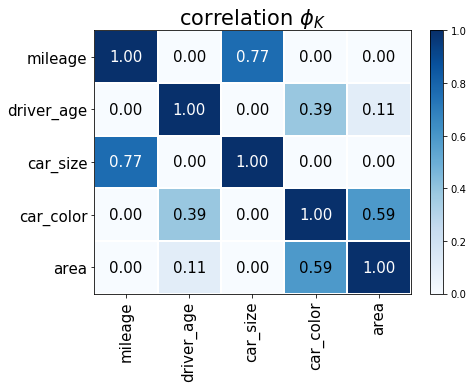

In [14]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(7,5.5))
plt.tight_layout()

# Global correlation: $g_k$

The global correlation coefficient is a measure of the total correlation of one variable to all other variables in the dataset. They give an indication of how well on variable can be modelled in terms of the other variables. A calculation of the global correlation coefficient is provided within the phik package.

In [15]:
global_correlation, global_labels = data.global_phik(interval_cols=interval_cols)
for c, l in zip(global_correlation, global_labels):
    print(l, c[0])

area 0.6057528003711345
car_color 0.6760317420050453
car_size 0.768588987856336
driver_age 0.41913005031633166
mileage 0.768588987856336


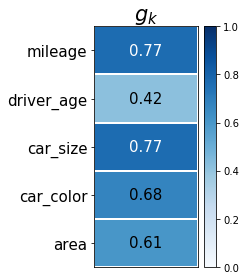

In [16]:
plot_correlation_matrix(global_correlation, x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=1.5)
plt.tight_layout()


# Statistical significance of the correlation: $Z$-score

When assessing correlations it is good practise to evaluate both the correlation and the significance of the correlation: a large correlation may be statistically insignificant, and vice versa a small correlation may be very significant. For instance, scipy.stats.pearsonr returns both the pearson correlation and the p-value. Similarly, the phik package offeres functionality the calculate a significance matrix. Significance is defined as:

$$Z = \Phi^{-1}(1-p)\ ;\quad \Phi(z)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z} e^{-t^{2}/2}\,{\rm d}t $$

Several corrections to the 'standard' p-value calculation are taken into account, making the method more rebust for low statistics and sparse data cases. The user is referred to our paper for more details.

As a result, the calculation may take a few seconds.

In [17]:
significance_overview = data.significance_matrix(interval_cols=interval_cols)
significance_overview

var2,area,car_color,car_size,driver_age,mileage
var1,,,,,
area,72.414143,37.597152,-0.292777,1.792994,-0.644337
car_color,37.597152,85.456758,-0.627259,19.823435,-0.636309
car_size,-0.292777,-0.627259,69.041964,-0.539766,49.224630
driver_age,1.792994,19.823435,-0.539766,84.350588,-0.706470
mileage,-0.644337,-0.636309,49.224630,-0.706470,91.208501


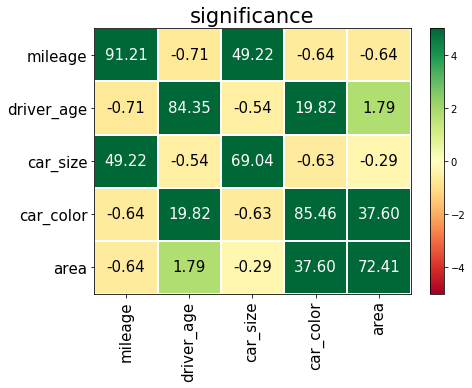

In [18]:
plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(7,5.5))
plt.tight_layout()

# Outlier significance

The normal pearson correlation between two interval variables is easy to interpret. However, the phik correlation between two variables of mixed type is not always easy to interpret, especially when it concerns categorical veriables. Therefore, functionality is providided to detect "outliers": excesses and deficicts over the exptected frequencies in the contigency table of two varaibles. 


### Example 1: car_color versus area

For the categorical variable pair car_color - area we measured:

$$\phi_k = 0.59 \, ,\quad\quad \mathrm{significance} = 37.6$$

Let's use the outlier signifiance functionality to gain a better understanding of the sigificance correlation between car color and area.


In [19]:
c1 = 'car_color'
c0 = 'area'

In [20]:
outlier_signifs, binning_dict = data[[c0,c1]].outlier_significance_matrix(retbins=True)
outlier_signifs

car_color,black,blue,gray,green,metalic,multicolor,red,white
area,,,,,,,,
country_side,-5.636485,-5.277175,-1.688032,5.824664,6.506020,0.092630,-2.282290,-1.193468
downtown,-16.444319,-8.209536,3.450521,14.176441,12.238785,2.582260,-3.863796,-4.400847
hills,-8.209536,3.054306,9.244711,-2.097600,-3.022553,4.789665,2.695864,-1.092375
suburbs,19.533221,8.315558,-8.209536,-8.209536,-8.209536,-6.529846,1.667814,3.964555
unpaved_roads,13.043553,-1.776804,-6.095289,-5.532779,-4.566500,-3.829519,-1.339881,1.074386


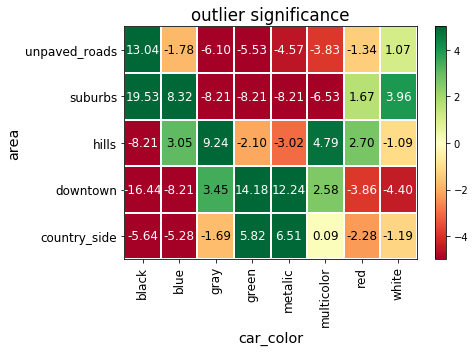

In [21]:
zvalues = outlier_signifs.values
xlabels = binning_dict[c1] if c1 in binning_dict.keys() else outlier_signifs.columns
ylabels = binning_dict[c0] if c0 in binning_dict.keys() else outlier_signifs.index
xlabel = c1
ylabel = c0

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2)

The significance of each cell is expressed in terms of Z (one-sided).

Interesting, owners of a green car are more likely to live in the country side, and black cars are more likely to travel on unpaved roads!

### Example 2: mileage versus car_size

For the categorical variable pair mileage - car_size we measured:

$$\phi_k = 0.77 \, ,\quad\quad \mathrm{significance} = 46.3$$

Let's use the outlier signifiance functionality to gain a better understanding of this sigificance correlation between mileage and car size.


In [22]:
c0 = 'mileage'
c1 = 'car_size'

tmp_interval_cols = ['mileage']

In [23]:
outlier_signifs, binning_dict = data[[c0,c1]].outlier_significance_matrix(interval_cols=tmp_interval_cols, 
                                                                          retbins=True)
outlier_signifs

car_size,L,M,S,XL,XS,XXL
53.5_30047.0,6.882155,21.483476,18.076204,-8.209536,10.820863,-22.423985
30047.0_60040.5,20.034528,-0.251737,-3.408409,2.534277,-1.973628,-8.209536
60040.5_90033.9,1.627610,-3.043497,-2.265809,10.215936,-1.246784,-8.209536
90033.9_120027.4,-3.711579,-3.827278,-2.885475,12.999048,-1.638288,-7.185622
120027.4_150020.9,-7.665861,-6.173001,-4.746762,9.629145,-2.841508,-0.504521
150020.9_180014.4,-7.533189,-6.063786,-4.660049,1.559370,-2.785049,6.765549
180014.4_210007.8,-5.541940,-4.425929,-3.360023,-4.802787,-1.942469,10.520540
210007.8_240001.3,-3.496905,-2.745103,-2.030802,-5.850529,-1.100873,8.723925
240001.3_269994.8,-5.275976,-4.207164,-3.186534,-8.616464,-1.830944,13.303101
269994.8_299988.2,-8.014016,-6.458253,-4.973240,-12.868389,-2.989055,20.992824


Note that the interval variable mileage is binned automatically in 10 uniformly spaced bins!

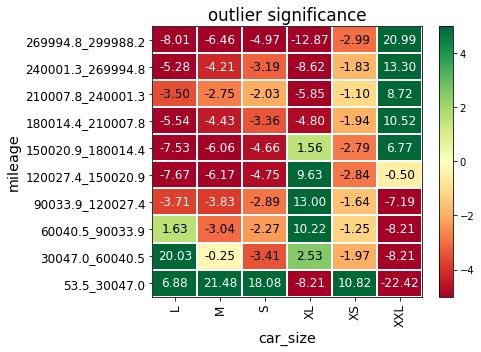

In [24]:
zvalues = outlier_signifs.values
xlabels = outlier_signifs.columns
ylabels = outlier_signifs.index
xlabel = c1
ylabel = c0

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2)

# Correlation report

A full correlation report can be created automatically for a dataset by pairwise evalation of all correlations, significances and outlier significances. 

Note that for a dataset with many different columns the number of outlier significances plots can grow large very rapidly. Therefore, the feature is implemented to only evaluate outlier significances for those variable pairs with a significance and correlation larger than the given thresholds.

interval_cols not set, guessing: ['driver_age', 'mileage']


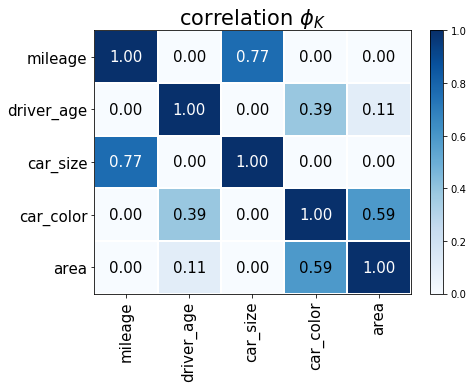

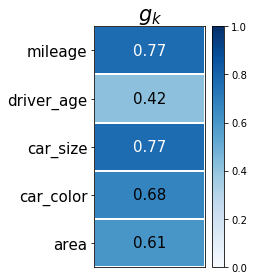

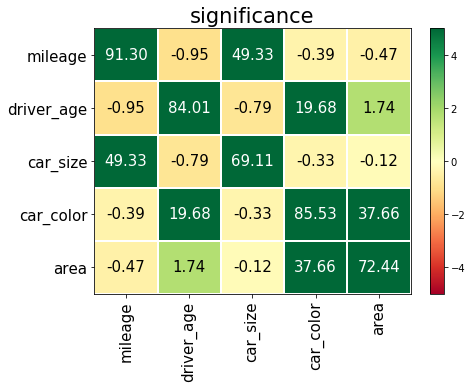

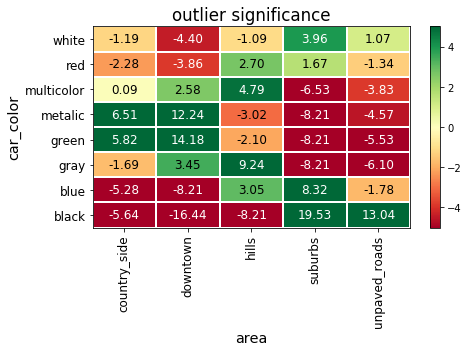

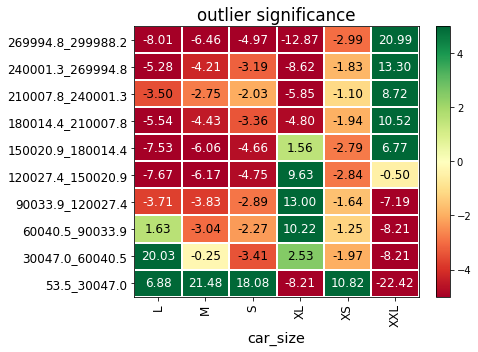

In [25]:
from phik import report
rep = report.correlation_report(data, significance_threshold=3, correlation_threshold=0.5)

# Recap

To summarize, the main functions in the phik correlation package working on a dataframe are:

- df[twocols].hist2d()
- df.phik_matrix()
- df.global_phik()
- df.significance_matrix()
- df.outlier_significance_matrix()  -- note: on a dataframe with exactly 2 columns
- df.outlier_significance_matrices()

In [26]:
data[['driver_age', 'mileage']].hist2d()

interval_cols not set, guessing: ['driver_age', 'mileage']


mileage,1,2,3,4,5,6,7,8,9,10
driver_age,,,,,,,,,,
1,54.0,30.0,13.0,29.0,57.0,61.0,36.0,11.0,36.0,61.0
2,51.0,41.0,13.0,17.0,64.0,41.0,35.0,12.0,30.0,75.0
3,65.0,29.0,21.0,24.0,53.0,54.0,35.0,14.0,27.0,66.0
4,49.0,23.0,17.0,30.0,50.0,54.0,21.0,17.0,25.0,53.0
5,41.0,28.0,19.0,15.0,33.0,45.0,27.0,11.0,23.0,39.0
6,21.0,12.0,5.0,12.0,26.0,25.0,10.0,8.0,10.0,15.0
7,7.0,8.0,2.0,3.0,8.0,9.0,4.0,2.0,3.0,10.0
8,5.0,2.0,0.0,1.0,6.0,1.0,1.0,1.0,1.0,3.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [27]:
data.phik_matrix()

interval_cols not set, guessing: ['driver_age', 'mileage']


var2,area,car_color,car_size,driver_age,mileage
var1,,,,,
area,1.000000,0.590456,0.000000,0.105506,0.000000
car_color,0.590456,1.000000,0.000000,0.389671,0.000000
car_size,0.000000,0.000000,1.000000,0.000000,0.768589
driver_age,0.105506,0.389671,0.000000,1.000000,0.000000
mileage,0.000000,0.000000,0.768589,0.000000,1.000000


In [28]:
data.global_phik()

interval_cols not set, guessing: ['driver_age', 'mileage']


(array([[0.6057528 ],
        [0.67603174],
        [0.76858899],
        [0.41913005],
        [0.76858899]]),
 array(['area', 'car_color', 'car_size', 'driver_age', 'mileage'],
       dtype=object))

In [29]:
data.significance_matrix()

interval_cols not set, guessing: ['driver_age', 'mileage']


var2,area,car_color,car_size,driver_age,mileage
var1,,,,,
area,72.414149,37.598215,-0.285072,1.833756,-0.632824
car_color,37.598215,85.465972,-0.636051,19.817000,-0.577392
car_size,-0.285072,-0.636051,69.049134,-0.496392,49.232915
driver_age,1.833756,19.817000,-0.496392,84.343356,-0.684187
mileage,-0.632824,-0.577392,49.232915,-0.684187,91.236359


In [30]:
data[['area', 'mileage']].outlier_significance_matrix()

interval_cols not set, guessing: ['mileage']


,53.5_30047.0,30047.0_60040.5,60040.5_90033.9,90033.9_120027.4,120027.4_150020.9,150020.9_180014.4,180014.4_210007.8,210007.8_240001.3,240001.3_269994.8,269994.8_299988.2
area,,,,,,,,,,
country_side,-0.178204,0.192584,0.099073,-1.818924,0.103907,0.888225,0.251480,1.491532,0.016080,-0.869129
downtown,0.625586,-2.141106,0.541785,0.931452,-0.926177,0.582585,0.917301,-0.729204,-0.978248,0.610302
hills,-0.826807,1.346029,-0.841090,0.008498,0.071356,1.028940,0.107051,0.080217,-0.397630,-0.904236
suburbs,0.972621,0.098196,0.712079,-0.059975,0.975536,-1.759184,-0.716170,-0.603623,0.059615,-0.050745
unpaved_roads,-1.469438,0.518041,-0.915745,-0.475005,-0.679357,-0.545607,-0.808321,0.901333,2.175620,1.339934


In [31]:
os_matrices = data.outlier_significance_matrices()

interval_cols not set, guessing: ['driver_age', 'mileage']


In [32]:
os_matrices.keys()

dict_keys(['car_color:driver_age', 'car_color:area', 'car_color:mileage', 'car_color:car_size', 'driver_age:area', 'driver_age:mileage', 'driver_age:car_size', 'area:mileage', 'area:car_size', 'mileage:car_size'])

In [33]:
os_matrices['car_color:mileage']

,53.5_30047.0,30047.0_60040.5,60040.5_90033.9,90033.9_120027.4,120027.4_150020.9,150020.9_180014.4,180014.4_210007.8,210007.8_240001.3,240001.3_269994.8,269994.8_299988.2
car_color,,,,,,,,,,
black,0.366425,1.387093,-1.320194,-1.274558,1.908010,-0.880578,-1.260293,-0.498607,-0.449794,0.492858
blue,-0.409760,-1.676495,-0.515491,1.969650,0.474818,-1.260466,-0.505987,-0.575699,1.675451,0.601026
gray,0.267888,-0.338430,-1.148378,0.048682,-0.238285,1.522769,1.282298,-0.812279,-0.589854,-0.887127
green,-0.195906,0.399471,1.306739,-0.918723,0.373229,-0.859866,-0.862544,0.772096,-0.169912,0.471057
metalic,0.697184,-0.385806,0.672620,0.205599,-1.543500,1.168147,0.249471,0.513459,-0.174870,-0.952009
multicolor,-0.478862,-0.591987,0.893783,0.050843,-2.104857,0.994621,0.109020,0.578461,-0.506460,1.287415
red,-0.551106,0.548949,1.370043,-0.050064,-1.822748,0.055521,2.208175,0.921955,0.219336,-1.556492
white,-0.055025,1.219026,-0.596627,-0.427730,1.888206,-0.471175,-0.851352,-0.393054,-0.697834,-0.323899
